# Noise Simulation Work Often Based on Qiskit Experiments

Let's get started! Taken from Qiskit Experiments documentation. Importantly this isn't the kind of noise we are too interested in...

In [1]:
# Create path to src directory
# use specified path if running on e.g. a HPC system 
import sys
sys.path.insert(1, '../src')

from qiskit_experiments.framework import BatchExperiment
from qiskit_experiments.library import QuantumVolume

# For simulation
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(5e-4, 1), ["sx", "x"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0, 1), ["rz"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(1e-2, 2), ["cx"])
backend = AerSimulator(noise_model=noise_model, seed_simulator=42)

In [2]:
qubits = tuple(range(4)) # Can use specific qubits. for example [2, 4, 7, 10]

qv_exp = QuantumVolume(qubits, seed=42)
# Transpile options like optimization_level affect only the real device run and not the simulation run
# Run options affect both simulation and real device runs
qv_exp.set_transpile_options(optimization_level=3)

# Run experiment
expdata = qv_exp.run(backend).block_for_results()

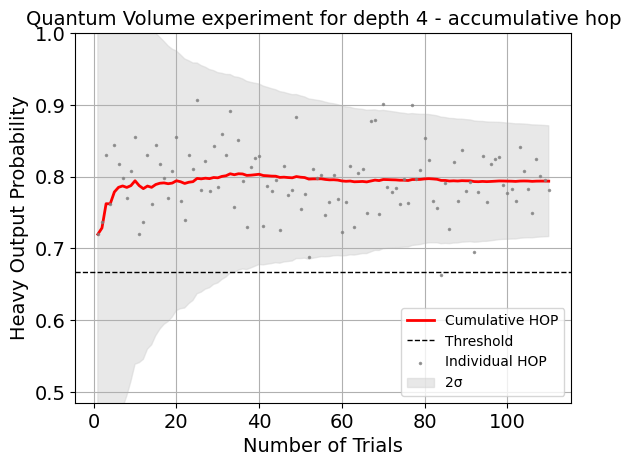

,name,experiment,components,value,quality,backend,run_time,HOPs,two_sigma,depth,trials,success,confidence
639c3996,mean_HOP,QuantumVolume,"[Q0, Q1, Q2, Q3]",0.79+/-0.04,good,aer_simulator,None,"[0.7197265625, 0.7373046875, 0.830078125, 0.76...",0.077156,4,110,None,None
fdd285e0,quantum_volume,QuantumVolume,"[Q0, Q1, Q2, Q3]",16,good,aer_simulator,None,None,None,4,110,True,0.999506


In [3]:
qv_exp.set_experiment_options(trials=10)
expdata2 = qv_exp.run(backend, analysis=None).block_for_results()
expdata2.add_data(expdata.data())
qv_exp.analysis.run(expdata2).block_for_results()

# View result data
display(expdata2.figure(0))
display(expdata2.analysis_results(dataframe=True))

# Randomised-Benchmarking

In [4]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits

# For simulation
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(5e-3, 1), ["sx", "x"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0, 1), ["rz"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(5e-2, 2), ["cx"])
backend = AerSimulator(noise_model=noise_model)

Gate error ratio: {'x': 1.0, 'rz': 0.0, 'sx': 1.0}


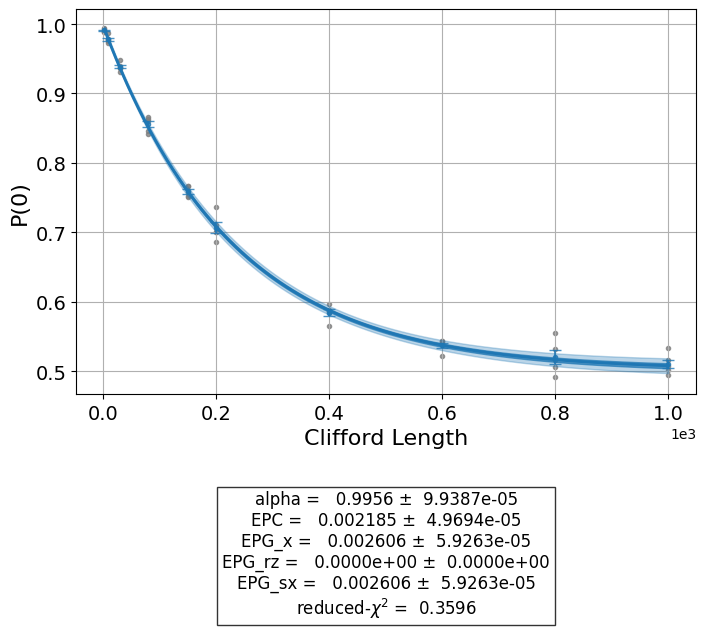

,name,experiment,components,value,quality,backend,run_time,chisq
0adb751f,alpha,StandardRB,[Q0],0.99563+/-0.00010,good,aer_simulator,None,0.359588
6efd7b85,EPC,StandardRB,[Q0],0.00219+/-0.00005,good,aer_simulator,None,0.359588
ec7c30c9,EPG_x,StandardRB,[Q0],0.00261+/-0.00006,good,aer_simulator,None,0.359588
d59235af,EPG_rz,StandardRB,[Q0],0.0+/-0,good,aer_simulator,None,0.359588
95d36d7c,EPG_sx,StandardRB,[Q0],0.00261+/-0.00006,good,aer_simulator,None,0.359588


In [5]:
lengths = [3, 10, 30, 80, 150] + np.arange(200, 1100, 200).tolist()
num_samples = 5
seed = 1010
qubits = [0]

# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()

# View result data
print("Gate error ratio: %s" % expdata1.experiment.analysis.options.gate_error_ratio)
display(expdata1.figure(0))
display(expdata1.analysis_results(dataframe=True))

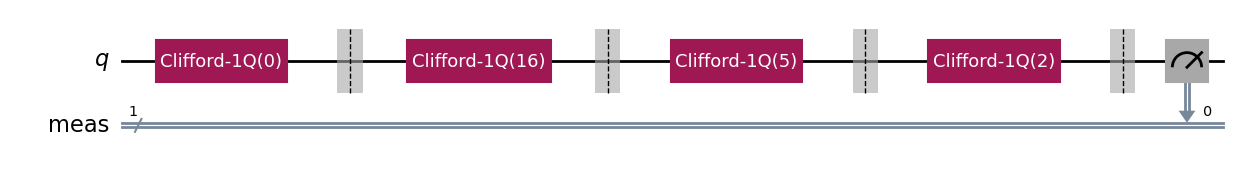

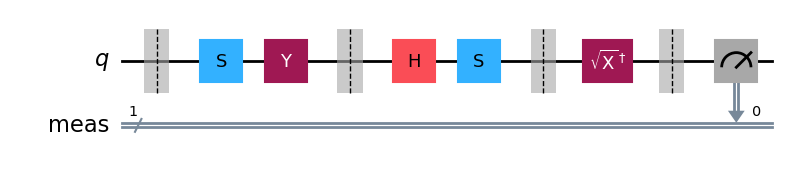

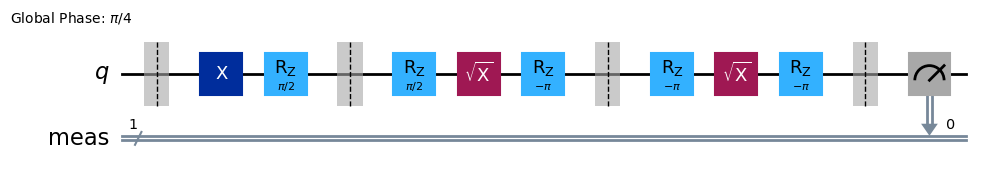

In [6]:
# Run an RB experiment on qubit 0
from qiskit import transpile
exp = StandardRB(qubits, [3], num_samples=num_samples, seed=27) #StandardRB(physical_qubits=(0,), lengths=[2], num_samples=1, seed=seed)
c = exp.circuits()[0]
display(c.draw(output="mpl", style="iqp"))
display(c.decompose().draw(output="mpl", style="iqp"))
display(transpile(c, backend, **vars(exp.transpile_options)).draw(output="mpl", style="iqp", idle_wires=False))